In [6]:
# Cell 1: 라이브러리 로드 & 경로 설정
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from pathlib import Path

# seaborn 테마 먼저 설정
sns.set_theme(style="whitegrid")

# 한글 폰트 설정 (matplotlib에서 한글 표시)
# seaborn 설정 후에 폰트를 지정해야 덮어쓰기 방지
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_prop = fm.FontProperties(fname=font_path)
plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

# 설정 확인 (디버깅용)
print(f"Current font family: {plt.rcParams['font.family']}")

DATA_DIR = Path("data")

Current font family: ['NanumGothic']


In [7]:
# Cell 2: JSONL 로드 (원본 + 토픽/과학 여부)
documents_df = pd.read_json(DATA_DIR / "documents.jsonl", lines=True)
eval_df = pd.read_json(DATA_DIR / "eval.jsonl", lines=True)
documents_topic_df = pd.read_json(DATA_DIR / "documents_topic.jsonl", lines=True)
eval_topic_df = pd.read_json(DATA_DIR / "eval_topic.jsonl", lines=True)

documents_df = documents_df.merge(
    documents_topic_df[["docid", "is_science", "topic"]],
    on="docid",
    how="left",
)
eval_df = eval_df.merge(
    eval_topic_df[["eval_id", "is_science", "topic"]],
    on="eval_id",
    how="left",
)

display(documents_df.head())
display(eval_df.head())

,docid,src,content,is_science,topic
0,42508ee0-c543-4338-878e-d98c6babee66,ko_mmlu__nutrition__test,건강한 사람이 에너지 균형을 평형 상태로 유지하는 것은 중요합니다. 에너지 균형은 ...,True,medicine
1,4a437e7f-16c1-4c62-96b9-f173d44f4339,ko_mmlu__conceptual_physics__test,"수소, 산소, 질소 가스의 혼합물에서 평균 속도가 가장 빠른 분자는 수소입니다. 수...",True,chemistry
2,d3c68be5-9cb1-4d6e-ba18-5f81cf89affb,ko_ai2_arc__ARC_Challenge__test,종이와 플라스틱은 재활용 가능한 자원입니다. 중학교 과학 수업에서 우리는 종이와 플...,True,earth_science
3,910107a6-2a42-41a2-b337-fbf22d6440fe,ko_ai2_arc__ARC_Challenge__test,마이애미파랑나비는 남부 플로리다에서 멸종 위기에 처한 종입니다. 이 나비의 개체수 ...,True,biology
4,74f22819-1a8e-4646-8a9d-13323de8cdb8,ko_ai2_arc__ARC_Challenge__validation,"비버는 나무를 베고, 덤불과 관목을 모아 강과 개울에 댐을 만드는 것으로 알려져 있...",True,biology


,eval_id,msg,is_science,topic
0,78,"[{'role': 'user', 'content': '나무의 분류에 대해 조사해 보...",True,biology
1,213,"[{'role': 'user', 'content': '각 나라에서의 공교육 지출 현...",False,education_policy
2,107,"[{'role': 'user', 'content': '기억 상실증 걸리면 너무 무섭...",True,medicine
3,81,"[{'role': 'user', 'content': '통학 버스의 가치에 대해 말해...",False,public_transportation
4,280,"[{'role': 'user', 'content': 'Dmitri Ivanovsky...",True,biology


In [8]:
# Cell 3: 시각화 헬퍼 함수들
def plot_is_science_bar(df, title):
    counts = df["is_science"].value_counts(dropna=False)
    fig, ax = plt.subplots(figsize=(5, 4))
    sns.barplot(x=counts.index.astype(str), y=counts.values, palette="muted", ax=ax)
    ax.set_xlabel("is_science")
    ax.set_ylabel("count")
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

def plot_topic_donut(df, title):
    counts = df["topic"].value_counts(dropna=False)
    labels = [str(lbl) for lbl in counts.index]
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.pie(
        counts.values,
        labels=labels,
        autopct="%1.1f%%",
        startangle=90,
        counterclock=False,
        wedgeprops=dict(width=0.35),
    )
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

def plot_topic_bar_science(df, title):
    sub = df[df["is_science"] == True]
    counts = sub["topic"].value_counts()
    fig, ax = plt.subplots(figsize=(7, max(3, len(counts) * 0.3)))
    sns.barplot(y=counts.index, x=counts.values, palette="viridis", ax=ax)
    ax.set_xlabel("count")
    ax.set_ylabel("topic")
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

def plot_topic_donut_nonscience(df, title):
    sub = df[df["is_science"] == False]
    counts = sub["topic"].value_counts(dropna=False)
    total_topics = len(counts)
    print(f"{title} - 전체 토픽 개수: {total_topics}개")
    
    # 상위 10개만 선택
    top_counts = counts.head(10)
    labels = [str(lbl) for lbl in top_counts.index]
    
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.pie(
        top_counts.values,
        labels=labels,
        autopct="%1.1f%%",
        startangle=90,
        counterclock=False,
        wedgeprops=dict(width=0.35),
    )
    ax.set_title(f"{title} (상위 10개)")
    plt.tight_layout()
    plt.show()

문서 토픽 개수: 208


/tmp/ipykernel_381248/3396514639.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index.astype(str), y=counts.values, palette="muted", ax=ax)


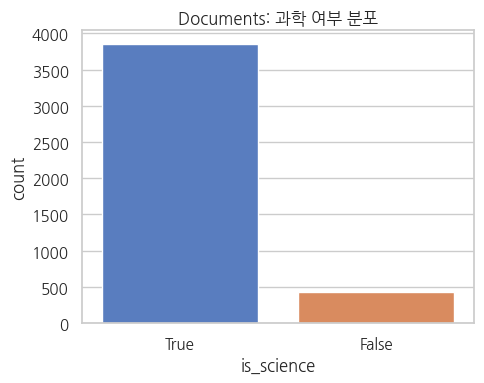

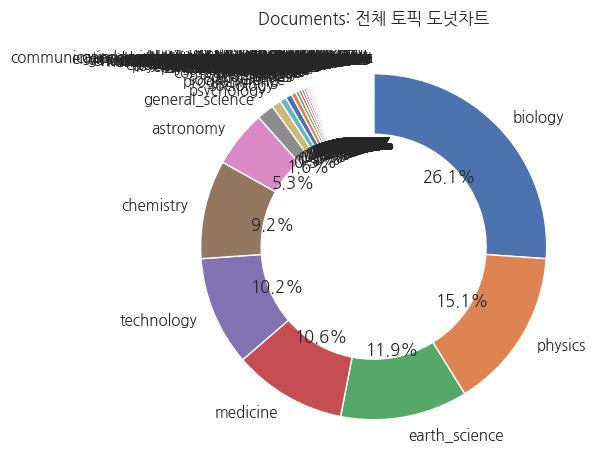

/tmp/ipykernel_381248/3396514639.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=counts.index, x=counts.values, palette="viridis", ax=ax)


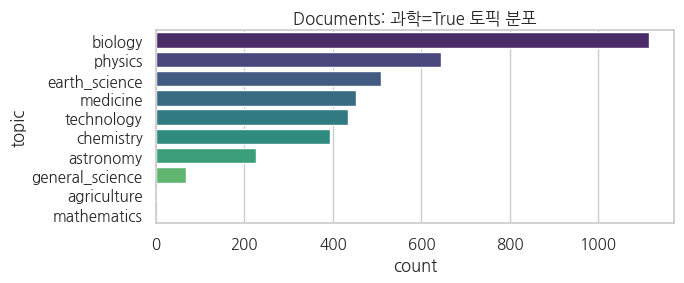

Documents: 과학=False 토픽 도넛차트 - 전체 토픽 개수: 201개


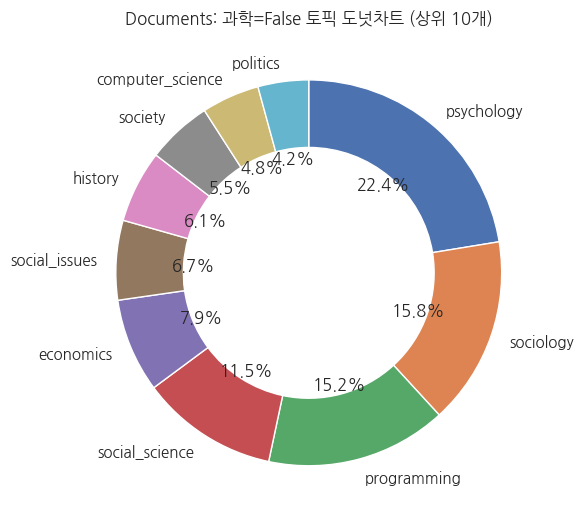

In [9]:
# Cell 4: 문서에 대한 분포
print("문서 토픽 개수:", documents_df["topic"].nunique())
plot_is_science_bar(documents_df, "Documents: 과학 여부 분포")
plot_topic_donut(documents_df, "Documents: 전체 토픽 도넛차트")
plot_topic_bar_science(documents_df, "Documents: 과학=True 토픽 분포")
plot_topic_donut_nonscience(documents_df, "Documents: 과학=False 토픽 도넛차트")


평가 질의 토픽 개수: 53


/tmp/ipykernel_381248/3396514639.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index.astype(str), y=counts.values, palette="muted", ax=ax)


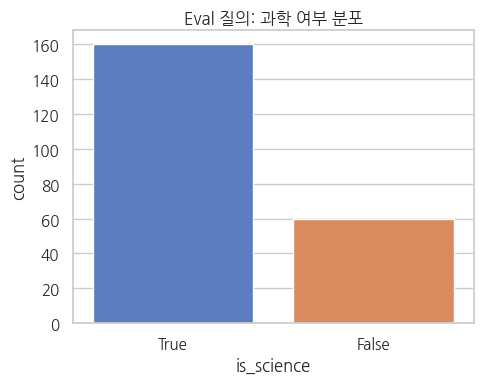

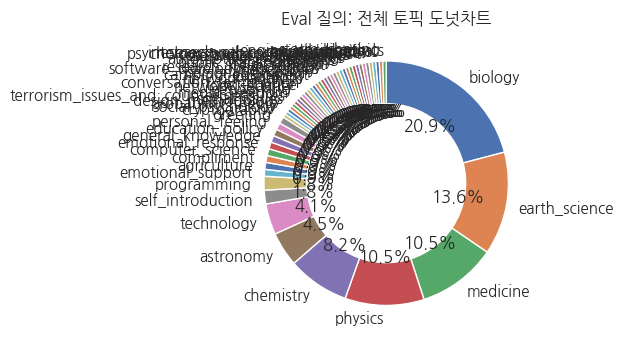

/tmp/ipykernel_381248/3396514639.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=counts.index, x=counts.values, palette="viridis", ax=ax)


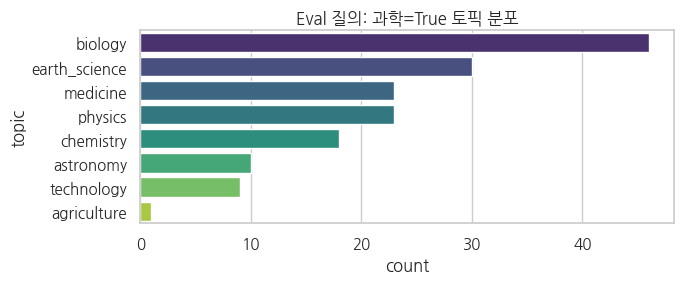

Eval 질의: 과학=False 토픽 도넛차트 - 전체 토픽 개수: 46개


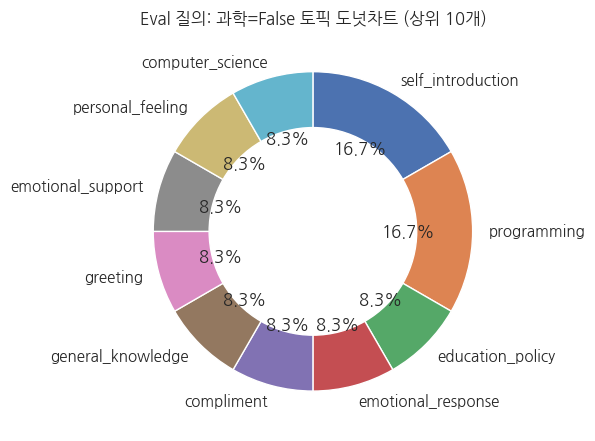

In [ ]:
# Cell 5: 평가 질의에 대한 분포
print("평가 질의 토픽 개수:", eval_df["topic"].nunique())
plot_is_science_bar(eval_df, "Eval 질의: 과학 여부 분포")
plot_topic_donut(eval_df, "Eval 질의: 전체 토픽 도넛차트")
plot_topic_bar_science(eval_df, "Eval 질의: 과학=True 토픽 분포")
plot_topic_donut_nonscience(eval_df, "Eval 질의: 과학=False 토픽 도넛차트")